<div class="alert alert-block alert-info">
<font size="6"><b><center> Section 6</font></center>
<br>
<font size="6"><b><center> Recurrent Neural Retwork II: Time Series Analysis </font></center>
</div>

# Example

In [68]:
import torch
import torch.nn as nn
from generate_data import *
import matplotlib.pyplot as plt

## Load and Examine Data

In [73]:
import pandas as pd

def loaddata (file):
    return pd.read_csv(file, header=None)

X = loaddata('data/Section6/series1_Xtrain.csv')
y = loaddata('data/Section6/series1_ytrain.csv')

def series_info(series):
    print('Shape  :', series.shape,'\n')
    print('Length :', len(series) ,'\n')
    print('Type   :', type(series),'\n')

series_info(X)
series_info(y)

Shape  : (80, 20) 

Length : 80 

Type   : <class 'pandas.core.frame.DataFrame'> 

Shape  : (80, 1) 

Length : 80 

Type   : <class 'pandas.core.frame.DataFrame'> 



## Examine the Series 

<Figure size 432x288 with 0 Axes>

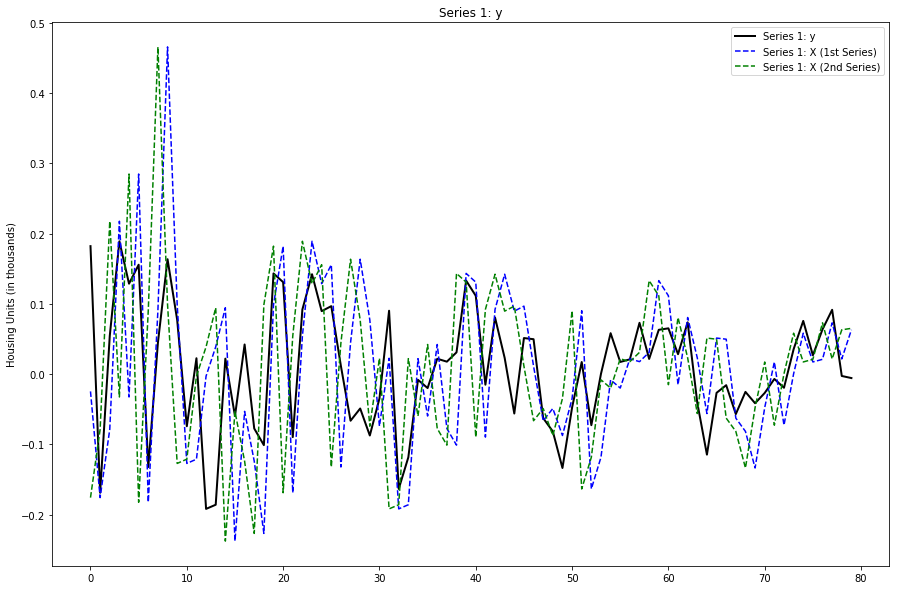

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
plt.figure(figsize=(15,10))

#plt.subplot(211)
plt.plot(y, 'black', linewidth=2, label = 'Series 1: y')
plt.plot(X.iloc[:,0], 'b--', label = 'Series 1: X (1st Series)')
plt.plot(X.iloc[:,1], 'g--', label = 'Series 1: X (2nd Series)')

plt.title('Series 1: y')
plt.xlabel('')
plt.ylabel('Housing Units (in thousands)')
plt.legend()

plt.show()

## Convert DataFrame into Tensors

In [76]:
# make training and test sets in torch
X_ts = torch.from_numpy(X.values).type(torch.Tensor)
y_ts = torch.from_numpy(y.values).type(torch.Tensor).view(-1)

X_ts = X_ts.view([input_size, -1, 1])
X_ts = X_ts.view([input_size, -1, 1])

## Set parameters

In [77]:
#####################
# Set parameters
#####################

# Network params
input_size = 20

h1 = 32
output_dim = 1
num_layers = 2
learning_rate = 1e-3
dtype = torch.float

In [78]:
print("X_ts type", type(X_ts))
print("y_ts type", type(y_ts))

print("X_ts shape", X_ts.shape)
print("y_ts shape", y_ts.shape)

X_ts type <class 'torch.Tensor'>
y_ts type <class 'torch.Tensor'>
X_ts shape torch.Size([20, 80, 1])
y_ts shape torch.Size([80])


## Build a LSTM model

In [79]:
#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # Initialise hidden state
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


/Users/jeffrey/anaconda2/envs/dl/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Train the model

In [87]:
hist = np.zeros(num_epochs)

n_epoch = 500

for epoch in range(1, n_epoch + 1):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_ts)

    loss = loss_fn(y_pred, y_ts)
    if epoch % 100 == 0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch-1] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  100 MSE:  0.33236637711524963
Epoch  200 MSE:  0.33188802003860474
Epoch  300 MSE:  0.3317567706108093
Epoch  400 MSE:  0.33287954330444336
Epoch  500 MSE:  0.33206337690353394


## Plot Performance

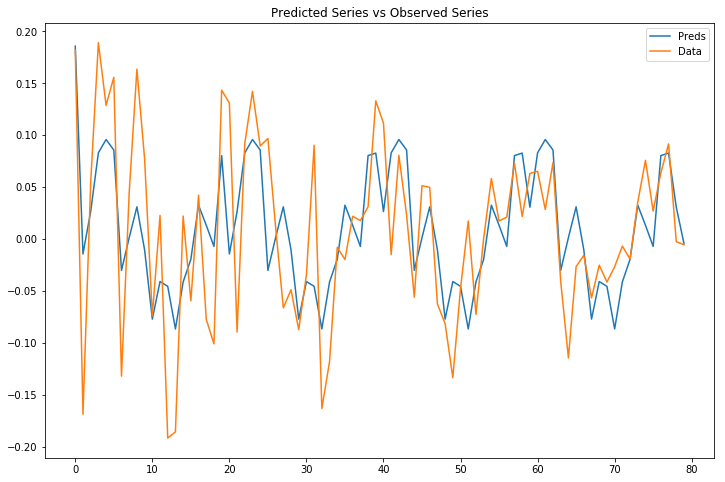

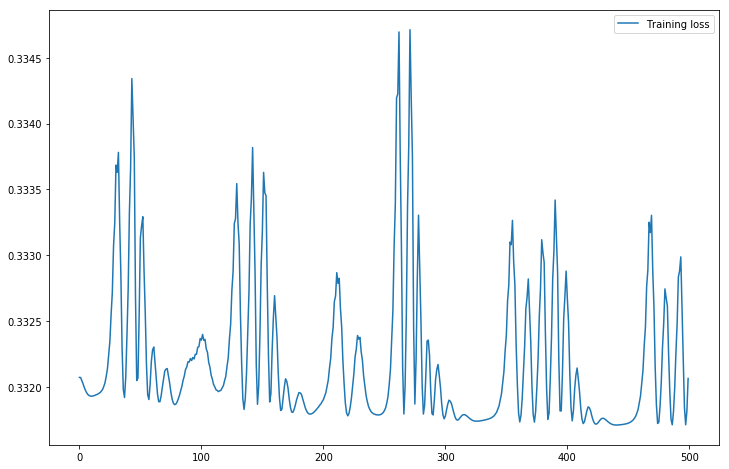

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(12,8))
plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_ts.detach().numpy(), label="Data")
plt.title('Predicted Series vs Observed Series')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()